In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nasir70daneshiar","key":"678246ada55cef62c70baf987384a917"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

# data gathering and prepration

In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
 ! kaggle datasets list

ref                                                        title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
themrityunjaypathak/covid-cases-and-deaths-worldwide       Covid Cases and Deaths WorldWide              8KB  2023-02-01 12:22:51           9578        317  1.0              
datascientistanna/customers-dataset                        Shop Customer Data                           23KB  2023-02-07 18:42:21           8036        198  1.0              
justin2028/unemployment-in-america-per-us-state            Unemployment in America, Per US State       826KB  2023-03-02 07:26:03            619         42  1.0              
anas123siddiqui/mobiles                                    Mobiles                                      59KB  2023-02-18 16:3

In [ ]:
! kaggle competitions download -c sentiment-analysis-on-movie-reviews

100% 1.90M/1.90M [00:01<00:00, 2.05MB/s]
100% 1.90M/1.90M [00:01<00:00, 1.81MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile('/content/sentiment-analysis-on-movie-reviews.zip','r') as zipref:
  zipref.extractall('./')


In [ ]:
with zipfile.ZipFile('/content/test.tsv.zip','r') as zipref:
  zipref.extractall('./')

In [ ]:
with zipfile.ZipFile('/content/train.tsv.zip','r') as zipref:
  zipref.extractall('./')

In [ ]:
import pandas as pd
df_tr = pd.read_csv('train.tsv',sep='\t')
df_te = pd.read_csv('test.tsv',sep='\t')

<AxesSubplot:>

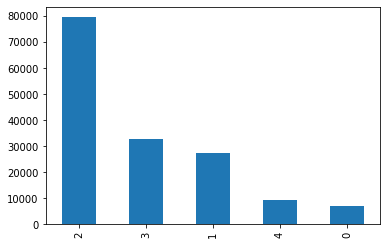

In [ ]:
df_tr['Sentiment'].value_counts().plot(kind='bar')

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 87.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 KB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 103.6 MB/s eta 0:00:00


In [ ]:
df_tr

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [ ]:
seq_len = 512
num_samples = len(df_tr)

from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
tokens = tokenizer(df_tr['Phrase'].tolist(),max_length=seq_len,
                   truncation = True, padding = 'max_length',
                   add_special_tokens = True,
                   return_tensors='np')


In [ ]:
len(df_tr)

156060

In [ ]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
import numpy as np
with open('movie_xids.npy','wb') as f:
  np.save(f, tokens['input_ids'])
with open('movie_xmask.npy','wb') as f:
  np.save(f, tokens['attention_mask'])

In [ ]:
arr = df_tr['Sentiment'].values
labels = np.zeros((num_samples, 5))
labels[np.arange(num_samples),arr]=1
with open('movie_labels.npy','wb') as f:
  np.save(f,labels)

# building a data set

In [ ]:
with open('/content/movie_xids.npy','rb') as f:
  Xids = np.load(f,allow_pickle=True)
with open('/content/movie_xmask.npy','rb') as f:
  Xmask = np.load(f,allow_pickle=True)
with open('/content/movie_labels.npy','rb') as f:
  labels = np.load(f,allow_pickle=True)

In [ ]:
import tensorflow as tf
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask,labels))

def map_function(input_ids,masks,labels):
  return {'input_ids':input_ids,'attention_mask':masks},labels


In [ ]:

dataset = dataset.map(map_function)

In [ ]:
dataset.element_spec

({'input_ids': TensorSpec(shape=(512,), dtype=tf.int64, name=None),
  'attention_mask': TensorSpec(shape=(512,), dtype=tf.int64, name=None)},
 TensorSpec(shape=(5,), dtype=tf.float64, name=None))

In [ ]:
batch_size = 16
split = 0.9
dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder = True)
size = int((Xids.shape[0]/batch_size)*split)
train_ds = dataset.take(size)
val_ds= dataset.skip(size)
tf.data.experimental.save(train_ds,'train')
tf.data.experimental.save(val_ds,'val')

Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.


In [ ]:
train_ds.element_spec

({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
  'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
 TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [ ]:
ds = tf.data.experimental.load('train',element_spec = train_ds.element_spec)

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


In [ ]:
for x,y in ds.take(1):
  print(x['input_ids'])
  print(y)

tf.Tensor(
[[  101 19857   102 ...     0     0     0]
 [  101   156  1918 ...     0     0     0]
 [  101 23665  2692 ...     0     0     0]
 ...
 [  101  3370   170 ...     0     0     0]
 [  101  8462  1769 ...     0     0     0]
 [  101   170 16358 ...     0     0     0]], shape=(16, 512), dtype=int64)
tf.Tensor(
[[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]], shape=(16, 5), dtype=float64)


# build and train model

In [ ]:
from transformers import TFAutoModel
bert = TFAutoModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
bert.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [ ]:
input_ids = tf.keras.layers.Input(shape=(512,),
                                  name='input_ids',dtype='int32')
mask = tf.keras.layers.Input(shape=(512,),
                                  name='attention_mask',dtype='int32')
# transformer
embeddings = bert.bert(input_ids, attention_mask = mask)[1]
# Classifier head
x = tf.keras.layers.Dense(1024,activation = 'relu')(embeddings)
y = tf.keras.layers.Dense(5, activation = 'softmax',name='outputs')(x)

In [ ]:
model = tf.keras.Model(inputs=[input_ids,mask], outputs=y)
model.layers[2].trainable = False
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer = optimizer, loss = loss, metrics = [acc])

In [ ]:
train_ds.element_spec

({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
  'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
 TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [ ]:
train_ds = tf.data.experimental.load('train',element_spec = train_ds.element_spec)
val_ds = tf.data.experimental.load('val',element_spec = train_ds.element_spec)
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 1
)

4619/8778 [==============>...............] - ETA: 47:26 - loss: 1.1227 - accuracy: 0.5531

In [ ]:
model.save('sentement_model')

# load_evaluate_predict

In [ ]:
model = tf.keras.models.load_model('sentement_model')



In [ ]:
tokens_te = tokenizer(df_te['Phrase'].tolist(),max_length=seq_len,
                   truncation = True, padding = 'max_length',
                   add_special_tokens = True,
                   return_tensors='np')
arr = df_te['Sentiment'].values
labels = np.zeros((num_samples, 5))
labels[np.arange(num_samples),arr]=1
dataset = tf.data.Dataset.from_tensor_slices((tokens_te['input_ids'], tokens_te['attention_mask'],labels))

def map_function(input_ids,masks,labels):
  return {'input_ids':input_ids,'attention_mask':masks},labels


In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
def prep_data(text):
  tokens = tokenizer(text,max_length= 512,trucation = True,
                     padding = 'max_length',add_special_tokens= True,
                     return_tenssors = 'tf')
  return {'input_ids': tokens['input_ids'],
          'attention_mask': tokens['attention_mask']}

In [ ]:
import numpy as np
np.argmax(model.predict(prep_data('this movie was tessible'))[0])